<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/convolution_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Networks

Let’s build some convolutional neural networks, also called convnets,
or more commonly, CNNs.

Each convolution layer holds a collection of
filters, or kernels, which are rectangles of numbers (often a small
square that is 3, 5, or 7 elements on a side). When we use 2D convolution
layers with images, each filter in the first layer is applied in turn
to every pixel in the input. The output of the filter becomes the value
of that element in a new tensor produced at the layer’s output. If there
are multiple filters, then the output tensor contains multiple channels,
just like the red, green, and blue channels of a color image.

We can characterize a convolution layer by
the number of dimensions in which the filters are moved. If the filter is
moved in just one dimension (for example, down), then we call it a 1D
convolution layer. Typically, when we work with images, we slide our
filters over the 2D width and height of the tensor, so we usually use 2D
convolution layers for image processing. Keras also offers 3D convolution
layers for working with volumetric data.

In practice we don’t often build and train
a new CNN from the ground up. Instead, we usually try to start with
an existing network whenever possible, and specialize it for our task
by perhaps modifying it, and then training it some more with our own
data. Such transfer learning is appealing because we get to start
with an existing architecture that is known to work well, and we save
the time (sometimes days or weeks) that was invested in training the
model we’re building upon. We also get the benefit of the data that
network was trained on, which might not be available to us.

But it’s important to know how to build our own from scratch. This
lets us start fresh when we need to, and gives us the tools to modify an
existing network when we want to. Whether we’re working with our
own model or one we’ve adopted, knowing what’s going on inside will
help us diagnose problems and get the best performance out of our
model.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Preparing the Data for A CNN

We prepare our MNIST data for a convnet with almost the same process
as we’ve been doing so far when the first layer was a Dense, or
fully-connected, layer.

The difference is in the shape of the feature data. So far, we’ve been
shaping our feature data in a 2D grid, with one row per image. Each
row held all the pixels for that image.

Something important happened when we flattened out our image
to make that grid: we lost the spatial information that tells us which
pixels are near one another vertically (technically, it’s still there, but
definitely not in a structure that’s easily useful). A great thing about
CNNs is that they work with inputs as multidimensional tensors, not
long 1D lists. For instance, the receptive field for a filter covers a group
of spatially-related elements.

When working with CNNs there’s no need to flatten out input 2D grids
of pixels. We’ll maintain them instead as three-dimensional volumes,
where each input image has a height, width, and depth.

The MNIST data is black and white, so we have just a single channel of
pixel data. But we still have to explicitly tell Keras that we have just that
one channel, by making it one of the dimensions of our input tensor.

Each image in the input will be reshaped as a 3D block
with dimensions 28 by 28 by 1, since we’re using the channels_last
convention. Then we stack all 60,000 of these 3D blocks together to
make a 4D tensor of shape 60,000 by 1 by 28 by 28, which will serve as
input to our CNN.

<img src='https://github.com/rahiakela/img-repo/blob/master/image-inputs.PNG?raw=1' width='800'/>

It can be easier to think of this not as a 4D
structure but instead as a sequence of nested lists: the outermost list
contains 60,000 images, each image contains one channel, each channel
contains 28 rows, and each row contains 28 elements.

Convnets work best with input data scaled from −1 to 1.This means we can’t just divide every pixel by 255. Instead, we’ll use
the NumPy function interp() to convert each input value in the range
[0,255] to the range [−1,1].

```python
X_train = np.interp(X_train, [0, 255], [-1, 1])
X_test = np.interp(X_test, [0, 255], [-1, 1])
```

Now we’ll re-shape the data into the shape we just discussed. We just
tell NumPy how to take our original version of X_train, which was
60,000 by 28 by 28, and reshape it into a 4D tensor that’s 60,000 by 1 by 28 by 28. We’re not changing the total number of elements, so
NumPy can do this for us.
```python
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)
```

We’ll place these re-shaping lines right after the scaling step. For completeness,all the pre-processing in one place.

In [0]:
random_seed = 42
np.random.seed(random_seed)

In [3]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

11493376/11490434 [==============================] - 0s 0us/step


Shaping the feature data into these 4D tensors is a necessary pre-processing
step. It puts the data into the structure that is expected by the
convolution layer that will sit at the start of our convnet.

In [0]:
# A little utility to draw accuracy and loss plots
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

## Convolution Layers

The Conv2D layer takes two unnamed, mandatory arguments at the
start of its argument list, followed by a variety of optional arguments.

The first mandatory argument is an integer specifying the number of
filters the layer should manage.Each filter
is applied to the input independently, and produces its own output. So
if our input has one channel (as our input does), and we use 5 filters
in a convolution layer, the output will have 5 channels.

<img src='https://github.com/rahiakela/img-repo/blob/master/image-channel-inputs.PNG?raw=1' width='800'/>

The second argument to Conv2D is a list that gives the dimensions of
the filters on this layer. if we have
5 filters and each is 3 by 3, then these arguments would be 5,[3,3].
This tells the layer to automatically allocate and initialize 5 volumes,
each of shape 3 by 3 by 1 (the trailing 1 is the number of channels).

In practice, we almost always use square kernels, often of 3 or 5 elements
on a side. Experience has shown that these sizes, coupled
with reduction in the size of the input (either by pooling or convolution
striding), represents a good tradeoff of computation and results.

Keep in mind that these filter kernels are 3D volumes, since there’s
one channel in the kernel for each channel in the input.

<img src='https://github.com/rahiakela/img-repo/blob/master/image-channel-inputs-1.PNG?raw=1' width='800'/>

Each filter automatically holds as many channels as there
are in the input. Here a 5 by 5 filter is being applied to a 3-channel input,
so the system automatically gives the filter 3 channels as well. Each of
the 75 values in the input (bottom) is multiplied by its corresponding
value in the filter (middle), and all of those products are added together
to produce a single number (top), the output of that filter for that location
of the input.

If we apply several filters to a multi-channel input, then
each filter will also have multiple channels. The number of channels in
the output is given by the number of filters that were used.

<img src='https://github.com/rahiakela/img-repo/blob/master/image-channel-inputs-2.PNG?raw=1' width='800'/>

let’s suppose that we’ve made a convolution layer with 5
filters, each 5 by 5. Then every output it produces will have 5 channels.
If the next layer is also a convolution layer, and we say that we want 2
filters that are 3 by 3, Keras will automatically know to make each filter
5 channels deep, since that’s what’s coming out of the previous layer.
In short, the number of channels in each filter is equal to the number
of channels in the input, which in turn is the number of filters used in
the previous convolution layer.

<img src='https://github.com/rahiakela/img-repo/blob/master/image-channel-inputs-3.PNG?raw=1' width='800'/>

Let’s make a convolution layer with 15 filters, each 3 by 3.

```python
convolution_layer = Conv2D(15, (3, 3))
model.add(convolution_layer)
```

In practice, we usually do this in one step.

```python
model.add(Conv2D(15, (3, 3)))
```

Now that we’ve covered all the background, let’s construct a 2D convolution
layer.

```python
model.add(Conv2D(16, (5, 5), activation='relu', strides=(2, 2), padding='same'),
            input_shape=(image_height, image_width, 1)))
```

Explanation:

* **padding**:To apply zero padding, we set the optional argument padding to the
string ′same′, meaning “make the output the same size as the input.”
The default value of padding is the string ′valid′, which means “only
place the filter where there is valid data available.” This is a longwinded
way of saying, “no padding.”

* **strides**:we set the stride values to (2,2), then our output
will be half the width and height as the input.

* **input_shape**: a CNN layer wants the input_shape to describe not
the shape of the whole data set, but just one sample.Therefore, the value of input_shape is the list (28,28,1), describing
one image.


## Using Convolution for MNIST

### A tiny convolutional neural network

Let’s build a CNN for categorizing MNIST images. To start with, we’ll
make a simple convnet with just one convolution layer, a flattening
layer, and a fully-connected output layer.

Our pre-processing step is unchanged. It reads in our data, normalizes it, re-shapes the features to the 4D channels-first tensor, and makes one-hot encodings for the labels.

<img src='https://github.com/rahiakela/img-repo/blob/master/simple-cnn-architecture.PNG?raw=1' width='800'/>

The architecture for a tiny convolutional neural network.
We have one convolutional layer with 32 filters, each a square of 5 by 5
elements. Following that is a flatten layer, and then a 10-neuron fully-connected
layer to present our categorization outputs.

In [0]:
def make_simple_cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(image_height, image_width, 1)))
  model.add(Flatten())
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
simple_cnn_model = make_simple_cnn_model()
simple_cnn_history = simple_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 34s 573us/sample - loss: 0.2989 - accuracy: 0.9137 - val_loss: 0.1091 - val_accuracy: 0.9698
Epoch 2/100
60000/60000 [==============================] - 33s 557us/sample - loss: 0.0879 - accuracy: 0.9748 - val_loss: 0.0700 - val_accuracy: 0.9783
Epoch 3/100
60000/60000 [==============================] - 33s 557us/sample - loss: 0.0623 - accuracy: 0.9813 - val_loss: 0.0633 - val_accuracy: 0.9811
Epoch 4/100
60000/60000 [==============================] - 34s 566us/sample - loss: 0.0509 - accuracy: 0.9843 - val_loss: 0.0537 - val_accuracy: 0.9836
Epoch 5/100
60000/60000 [==============================] - 34s 561us/sample - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0567 - val_accuracy: 0.9825
Epoch 6/100
60000/60000 [==============================] - 34s 561us/sample - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.0534 - val_accuracy: 0.9837
Epoch 7/100
60000/60000 [=============

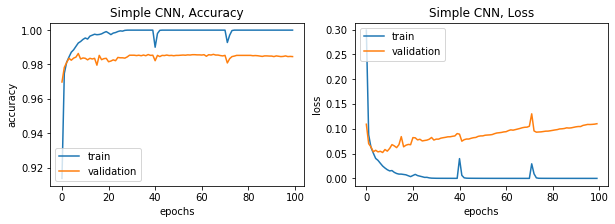

In [0]:
plot_accuracy_and_loss(simple_cnn_history, 'Simple CNN')

The good news about these results is that everything seems to be working
pretty well. Our system learns the training data and does a good
job predicting the classes of the validation data, getting about 98.6%
accuracy.

On the other hand, these curves aren’t really looking great. The training
accuracy gets up to about 1.0 within 35 epochs or so, and the
validation accuracy seems to plateau about there as well. That’s okay,
but the loss curves tell a different story. The system starts overfitting
before even 10 epochs are done, and it just gets worse as time goes on.

### A begger convolutional neural network

Let’s guess that maybe we would see better performance if we used a
deeper model. We’ll increase the number of convolution layers from 1
to 3, and to control overfitting we’ll add dropout after each one.

<img src='https://github.com/rahiakela/img-repo/blob/master/bigger-cnn-architecture.PNG?raw=1' width='800'/>

The first convolution layer uses 16 filters of 5 by 5, and then we follow
that with two layers that use 8 filters of 3 by 3. All of these numbers are
more or less arbitrary, resulting from an initial guess and then some
trial and error. We follow each convolution layer with a dropout layer,
and at the end we flatten the result and feed it to a 10-neuron dense
layer using softmax, as usual.

Because we’re using the border_mode=′same′ option, and the default
stride of 1 by 1, the output of each convolution will be the same width
and height as the input.

Note that
we’re setting the optional argument kernel_constraint to the value
maxnorm(3), just as we did with the Dense layers earlier. For convolution
layers it prevents the values in the filters from getting too big, in
the same way that it prevented the weights in the Dense layers from
getting too big.

In [0]:
np.random.seed(random_seed)
keras_backend.clear_session()

In [0]:
def make_bigger_cnn_model():
  model = Sequential()
  model.add(Conv2D(16, (5, 5), activation='relu', padding='same', kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
bigger_cnn_model = make_bigger_cnn_model()
bigger_cnn_history = bigger_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.4266 - accuracy: 0.8698 - val_loss: 0.1130 - val_accuracy: 0.9652
Epoch 2/100
60000/60000 [==============================] - 95s 2ms/sample - loss: 0.1183 - accuracy: 0.9637 - val_loss: 0.0709 - val_accuracy: 0.9780
Epoch 3/100
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.0876 - accuracy: 0.9732 - val_loss: 0.0529 - val_accuracy: 0.9831
Epoch 4/100
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.0744 - accuracy: 0.9769 - val_loss: 0.0496 - val_accuracy: 0.9847
Epoch 5/100
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.0653 - accuracy: 0.9801 - val_loss: 0.0533 - val_accuracy: 0.9827
Epoch 6/100
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.0384 - val_accuracy: 0.9869
Epoch 7/100
60000/60000 [=========================

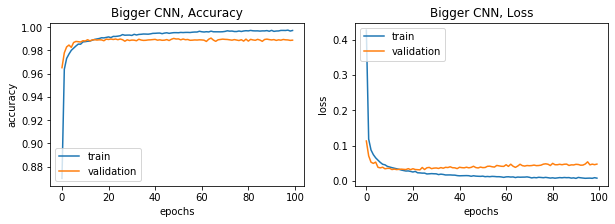

In [0]:
plot_accuracy_and_loss(bigger_cnn_history, 'Bigger CNN')

We’ve pretty much eliminated overfitting, though the validation accuracy
is just a bit lower than before. As far as validation accuracy goes,
it seems we could have stopped after about 40 epochs.



### A convolutional neural network with dropout and pooling layers

Let’s try making the image smaller and smaller as it works its way
through the network. This way each layer gets to work with larger
pieces of the original image.

We’ll do this first using pooling layers. Though we’ve noted pooling
layers are falling out of favor in convnets, we’ll use them now because
they let us explicitly show how the tensor gets reduced in size as it
flows through the network.

Each pooling layer will look at 2 by 2 non-overlapping boxes, and
return the largest value in that group of 4 input elements. As a result, the output of each of these layers will have half the width and height of its input. The input images are 28 by 28, so the output of the first max pooling layer will be 14 by 14, and the output of the second will be 7 by 7. Of course, the depth of each of these tensors is given by the number
of filters in the preceding convolution layer.

<img src='https://github.com/rahiakela/img-repo/blob/master/dropout-pooling-cnn-architecture.PNG?raw=1' width='800'/>


In [0]:
keras_backend.clear_session()
np.random.seed(random_seed)

In [0]:
def make_pooling_cnn_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), activation='relu', padding='same', kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
pooling_cnn_model = make_pooling_cnn_model()
pooling_cnn_history = pooling_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 132us/sample - loss: 0.3382 - accuracy: 0.9003 - val_loss: 0.0993 - val_accuracy: 0.9773
Epoch 2/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0775 - accuracy: 0.9760 - val_loss: 0.0553 - val_accuracy: 0.9842
Epoch 3/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0575 - accuracy: 0.9819 - val_loss: 0.0564 - val_accuracy: 0.9854
Epoch 4/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0409 - val_accuracy: 0.9875
Epoch 5/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0388 - accuracy: 0.9876 - val_loss: 0.0360 - val_accuracy: 0.9891
Epoch 6/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0449 - val_accuracy: 0.9876
Epoch 7/100
60000/60000 [========================

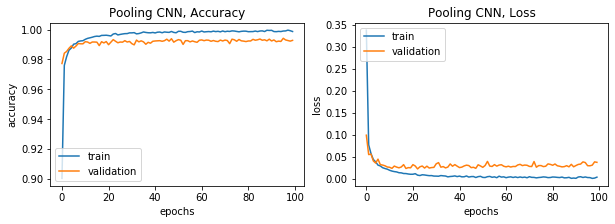

In [0]:
plot_accuracy_and_loss(pooling_cnn_history, 'Pooling CNN')

We’ve picked up a small but meaningful increase in validation accuracy,
from 0.9879 to 0.9939. As we mentioned earlier, progress at this
point often proceeds in tiny steps. This is actually pretty large, since
we’ve shaved off almost half of the distance to 1.

And we seem to have no overfitting. In fact, after about the 50th epoch
everything things pretty much settled.

### A convolutional neural network with dropout and striding layers

The pooling layers after convolution are being replaced
these days by striding in the convolution layers themselves. 

Let’s implement this and replace the 2 by 2 max pooling layers with 2 by
2 striding. The results will be a little different, because the process of
striding the convolution kernels is not identical to moving them by
single steps and then pooling, but we’d expect a rough similarity.

<img src='https://github.com/rahiakela/img-repo/blob/master/strides-cnn-architecture.PNG?raw=1' width='800'/>


In [0]:
keras_backend.clear_session()
np.random.seed(random_seed)

In [0]:
def make_striding_cnn_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), activation='relu', padding='same', strides=(2, 2), kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(Dropout(0.2))

  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2), kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [7]:
striding_cnn_model = make_striding_cnn_model()
striding_cnn_history = striding_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 104us/sample - loss: 0.5069 - accuracy: 0.8405 - val_loss: 0.1240 - val_accuracy: 0.9650
Epoch 2/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1438 - accuracy: 0.9551 - val_loss: 0.0683 - val_accuracy: 0.9786
Epoch 3/100
60000/60000 [==============================] - 1s 25us/sample - loss: 0.1013 - accuracy: 0.9690 - val_loss: 0.0579 - val_accuracy: 0.9804
Epoch 4/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0841 - accuracy: 0.9737 - val_loss: 0.0507 - val_accuracy: 0.9841
Epoch 5/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0725 - accuracy: 0.9768 - val_loss: 0.0407 - val_accuracy: 0.9861
Epoch 6/100
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.0364 - val_accuracy: 0.9882
Epoch 7/100
60000/60000 [========================

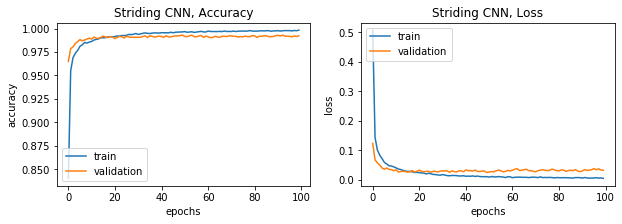

In [8]:
plot_accuracy_and_loss(striding_cnn_history, 'Striding CNN')

We’ve lost a very tiny bit of accuracy in both the training and validation
sets, but otherwise these numbers and their graph look pretty much
like what we saw from using explicit pooling layers.

Can we increase performance even more?

We can play with any aspect of our network. We can add or remove
filters at each layer, change their size, increase the dropout percentage,
add more convolution layers, and so on.

### A convolutional neural network with Batch Normalization and Striding layers

Just for variety, let’s try replacing the dropout layers with batchnorm layers. Both are designed to reduce overfitting, so we can see which of the two techniques works best for this network and this data.

<img src='https://github.com/rahiakela/img-repo/blob/master/batchnorm-strides-cnn-architecture.PNG?raw=1' width='800'/>

We’re setting the activation parameter in the convolution layers to None, because, batchnorm operates between a layer’s output
and its activation function. So we follow each convolution layer with
a BatchNormalization layer, and then a layer to apply the ReLU activation
function (batch normalization was designed to take
place after a layer’s outputs, but before the activation function).

In [0]:
keras_backend.clear_session()
np.random.seed(random_seed)

In [0]:
def make_striding_batchnorm_cnn_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), activation=None, padding='same', strides=(2, 2), kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(16, (3, 3), activation=None, padding='same', strides=(2, 2), kernel_constraint=max_norm(3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [11]:
striding_batchnorm_cnn_model = make_striding_batchnorm_cnn_model()
striding_batchnorm_cnn_history = striding_batchnorm_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 37us/sample - loss: 0.2670 - accuracy: 0.9219 - val_loss: 0.1878 - val_accuracy: 0.9572
Epoch 2/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0648 - accuracy: 0.9814 - val_loss: 0.0539 - val_accuracy: 0.9834
Epoch 3/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0430 - accuracy: 0.9868 - val_loss: 0.0418 - val_accuracy: 0.9861
Epoch 4/100
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0327 - accuracy: 0.9898 - val_loss: 0.0465 - val_accuracy: 0.9855
Epoch 5/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0389 - val_accuracy: 0.9886
Epoch 6/100
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.0504 - val_accuracy: 0.9851
Epoch 7/100
60000/60000 [=========================

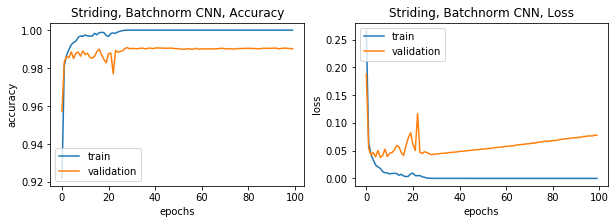

In [12]:
plot_accuracy_and_loss(striding_batchnorm_cnn_history, 'Striding, Batchnorm CNN')

The validation accuracy is about the same as we got before, but we
seem to have picked up a small amount of overfitting.

Overall, this variation doesn’t seem to have given us anything better
than before. This is the value of experimenting: until we try, we can’t
be sure how a network and a particular data set will behave.

## Patterns

Historically, many CNNs were assembled by repeating a few types
of recognizable blocks of layers. Such a block is a set
of convolution layers, followed by a pooling layer. This block is then
repeated several times, perhaps with different parameters to the convolution
layers. After that comes a series of fully-connected layers.

<img src='https://github.com/rahiakela/img-repo/blob/master/pattern-1-cnn-architecture.PNG?raw=1' width='800'/>

The pooling layers usually tile the input with 2 by 2 blocks. That is, the
receptive field is 2 by 2, and we use a stride of (2,2) so that we produce
a tiling with no overlaps or holes. This makes an output that has half
the width and height of the input.

This network is a simplified version of the VGG16 network, drawn here to demonstrate the idea of repeated units, but just
for fun, let’s run this on the MNIST data.


In [0]:
keras_backend.clear_session()
np.random.seed(random_seed)

In [0]:
def make_pattern_1_cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (5, 5), activation=None, padding='same', input_shape=(image_height, image_width, 1)))
  model.add(Conv2D(32, (5, 5), activation=None, padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
  model.add(Conv2D(16, (3, 3), activation=None, padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
  model.add(Conv2D(8, (3, 3), activation=None, padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [16]:
pattern_1_cnn_model = make_pattern_1_cnn_model()
pattern_1_cnn_history = pattern_1_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.2505 - accuracy: 0.9210 - val_loss: 0.0726 - val_accuracy: 0.9787
Epoch 2/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0673 - accuracy: 0.9794 - val_loss: 0.0513 - val_accuracy: 0.9841
Epoch 3/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0436 - accuracy: 0.9863 - val_loss: 0.0380 - val_accuracy: 0.9886
Epoch 4/100
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.0472 - val_accuracy: 0.9845
Epoch 5/100
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0306 - accuracy: 0.9898 - val_loss: 0.0528 - val_accuracy: 0.9845
Epoch 6/100
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0438 - val_accuracy: 0.9868
Epoch 7/100
60000/60000 [=========================

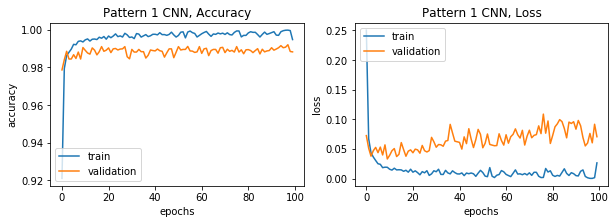

In [17]:
plot_accuracy_and_loss(pattern_1_cnn_history, 'Pattern 1 CNN')

This isn’t the best data we’ve seen, and there’s some overfitting, but it’s
not bad for an essentially arbitrary network. It does take quite a while
to run each epoch, as we might expect from all those layers.

As we did before, let’s replace the pooling layers with striding in the
final convolution layer of each set.We usually leave
the stride of the other layers at 1. This is becoming a more attractive
option as omitting the pooling layers gives us a smaller and faster
network, and when things are well-tuned there seems to be no loss
of performance. The stride sizes are
often (2,2), as they were for the pooling layers we’re replacing.

<img src='https://github.com/rahiakela/img-repo/blob/master/pattern-2-cnn-architecture.PNG?raw=1' width='800'/>

In [0]:
keras_backend.clear_session()
np.random.seed(random_seed)

In [0]:
def make_pattern_2_cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (5, 5), activation=None, padding='same', input_shape=(image_height, image_width, 1)))
  model.add(Conv2D(32, (5, 5), activation=None, padding='same', strides=(2, 2)))

  model.add(Conv2D(16, (5, 5), activation=None, padding='same'))
  model.add(Conv2D(16, (3, 3), activation=None, padding='same', strides=(2, 2)))

  model.add(Conv2D(8, (5, 5), activation=None, padding='same'))
  model.add(Conv2D(8, (3, 3), activation=None, padding='same', strides=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [20]:
pattern_2_cnn_model = make_pattern_2_cnn_model()
pattern_2_cnn_history = pattern_2_cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2504 - accuracy: 0.9236 - val_loss: 0.1220 - val_accuracy: 0.9581
Epoch 2/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0968 - accuracy: 0.9704 - val_loss: 0.0998 - val_accuracy: 0.9678
Epoch 3/100
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0734 - accuracy: 0.9765 - val_loss: 0.0776 - val_accuracy: 0.9762
Epoch 4/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0551 - accuracy: 0.9821 - val_loss: 0.0729 - val_accuracy: 0.9775
Epoch 5/100
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.0737 - val_accuracy: 0.9768
Epoch 6/100
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0401 - accuracy: 0.9866 - val_loss: 0.0685 - val_accuracy: 0.9793
Epoch 7/100
60000/60000 [=========================

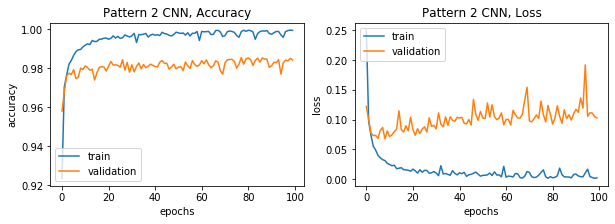

In [21]:
plot_accuracy_and_loss(pattern_2_cnn_history, 'Pattern 2 CNN')

The results are just a little noisier than before, but they land in roughly
the same place.This makes sense, since convolution with striding
means we apply the convolution filter less frequently, and we can skip
the subsequent post processing step of pooling altogether.